---

<h1><div align="center"><font color='blue'>  Wing Hang CHAN (s3939713) </font></div></h1>
<h1><div align="center"><font color='blue'> COSC 2779 | Deep Learning  </font></div></h1>
<h2><div align="center"> <font color='blue'> Assignment 2 <strong>Sequence Processing with Deep learning<strong> </font></div></h2>
<br>

---

# Preparation
## Google Colab Installation libraries

In [1]:
!pip install fasttext -q
!pip install nlpaug -q
!pip install transformers -q

## Import Libraries

In [4]:
# import fasttext.util
# import nlpaug.augmenter.word as naw
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

from itertools import cycle
from matplotlib import pyplot as plt
from nltk.tokenize import TweetTokenizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, GlobalMaxPooling2D, Bidirectional, Flatten, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Reading Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp /content/drive/'My Drive'/Deeplearning/assg2/train.csv .
!cp /content/drive/'My Drive'/Deeplearning/assg2/test.csv .
!ls

cc.en.300.bin.gz.part  drive  sample_data  test.csv  train.csv


In [5]:
df = pd.read_csv("train.csv", encoding="unicode_escape", lineterminator='\r')
df.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [6]:
df_test = pd.read_csv("test.csv", encoding="unicode_escape", lineterminator='\r')
df_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


# EDA - Exploratory Data Analysis

## Tweet
Tweet is a text content which limited to 280 characters or Unicode glyphs. It can have hashtags, mentions or Retweets.

A hashtag is a words or phrases preceded by the "#" symbol.

A mention is a tag of other X users by using a '@' forllowed by their username. A username can only contain alphanumeric characters (letters A-Z, numbers 0-9) except underscores.

A Retweet(RT) / Repost is a re-posting of a post. It could be your own posts or posts from others. There is no official X command or feature of using "RT" at the beginning of a post for indicating a RT. But, a RT looks like that by following the author's name and username.

## Stance
Stance refers to an individual's or entity's position, viewpoint, or attitude regarding a particular topic, issue, or argument. It represents one's perspective or stance on a given subject and can range from being in favor of that subject to being against or even being neutral.

ref:
X Corp. - "Counting characters", online available: https://developer.twitter.com/en/docs/counting-characters
X Corp. - "Help with username registration", online available: https://help.twitter.com/en/managing-your-account/x-username-rules
X Corp. - "RePost FAQs", online available: https://help.twitter.com/en/using-x/repost-faqs

Patterns of Mention, Retweet & Hashtag

In [7]:
mention_pattern = r'@[A-z0-9_]{2,}'
retweet_pattern = r'RT\s'+mention_pattern+r':\s?'
hashtag_pattern = r'(#[A-z0-9_]+)'

## 1. Describing Data set
### Train set

In [8]:
df.describe()

,Tweet,Target,Stance,Opinion Towards,Sentiment
count,2914,2914,2914,2914,2914
unique,2914,5,3,3,3
top,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
freq,1,689,1395,1716,1762


### Test set

In [9]:
df_test.describe()

,Tweet,Target,Stance,Opinion Towards,Sentiment
count,1956,1956,1956,1956,1956
unique,1956,6,3,3,3
top,He who exalts himself shall be humbled; a...,Donald Trump,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
freq,1,707,1014,1148,1272


## 2. Types of Varibles
i. Stances
ii. Opinion Towards
iii. Sentiment

In [10]:
print(f"Stances in data set: {sorted(df['Stance'].unique())}")
print(f"Difference of Targets: {df_test['Stance'][~df_test['Stance'].isin(df['Stance'])].unique()}")

print(f"Opinion Towards in data set: {sorted(df['Opinion Towards'].unique())}")
print(f"Difference of Opinion Towards: {df_test['Opinion Towards'][~df_test['Opinion Towards'].isin(df['Opinion Towards'])].unique()}")

print(f"Sentiment in data set: {sorted(df['Sentiment'].unique())}")
print(f"Difference of Sentiment: {df_test['Sentiment'][~df_test['Sentiment'].isin(df['Sentiment'])].unique()}")


Stances in data set: ['AGAINST', 'FAVOR', 'NONE']
Difference of Targets: []
Opinion Towards in data set: ['1.  The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.', '2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.', '3.  The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)']
Difference of Opinion Towards: []
Sentiment in data set: ['neg', 'other', 'pos']
Difference of Sentiment: []


Columns `Opinion Towards` and `Sentiment` are not used to classify the stance. Therefore, the two columns are removed.

iv. Targets
Differences in Train and Test set

In [11]:
print(f"Targets in train set: {sorted(df['Target'].unique())}")
print(f"Targets in test set: {sorted(df_test['Target'].unique())}")

print(f"Difference of Targets: {df_test['Target'][~df_test['Target'].isin(df['Target'])].unique()}")

Targets in train set: ['Atheism', 'Climate Change is a Real Concern', 'Feminist Movement', 'Hillary Clinton', 'Legalization of Abortion']
Targets in test set: ['Atheism', 'Climate Change is a Real Concern', 'Donald Trump', 'Feminist Movement', 'Hillary Clinton', 'Legalization of Abortion']
Difference of Targets: ['Donald Trump']


There are 2914 records in train set and 1956 in test set. The training and testing ratio is about 60-40. There are 3 types of `Stance` in both training and test set. But, there are 5 `Targets` in training set and 6 `Targets` in test set. The difference between them is "Donald Trump".

In [12]:
df = df[['Tweet','Target','Stance']]
df_test = df_test[['Tweet','Target','Stance']]

## 3. Imbalance of Dataset
### i. Targets

Text(0, 0.5, 'Targets')

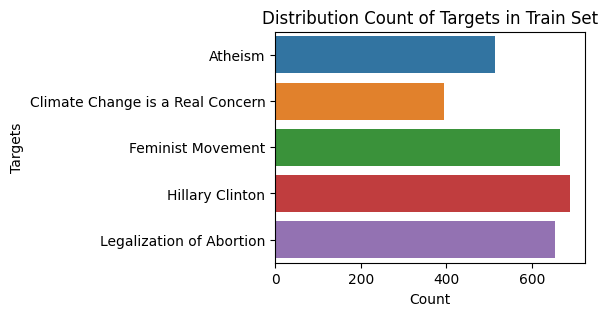

In [13]:
df_grouped_2 = df.groupby('Target').size().reset_index(name='Count')
fig = plt.figure(figsize=(4,3))

sns.barplot(x='Count', y='Target', orient='h', data=df_grouped_2)

plt.title("Distribution Count of Targets in Train Set")
plt.xlabel("Count")
plt.ylabel("Targets")

Text(0, 0.5, 'Targets')

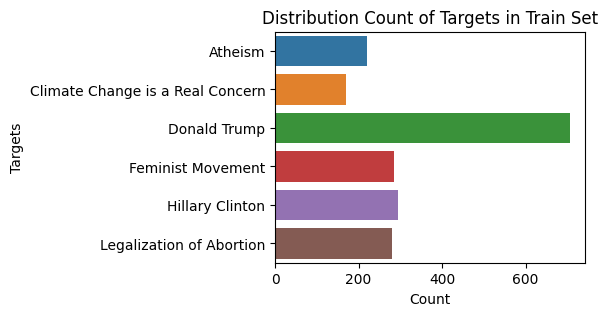

In [14]:
df_test_grouped_2 = df_test.groupby('Target').size().reset_index(name='Count')
fig = plt.figure(figsize=(4,3))

sns.barplot(x='Count', y='Target', orient='h', data=df_test_grouped_2)

plt.title("Distribution Count of Targets in Train Set")
plt.xlabel("Count")
plt.ylabel("Targets")

### ii. Stances Imbalance for Targets (Bias)

In [15]:
df_grouped = df.groupby(['Target','Stance']).size().reset_index(name='Count')
counts_target = df_grouped.groupby('Target')['Count'].transform('sum')
df_grouped['Percentage'] = (df_grouped['Count'] / counts_target) * 100
df_grouped

,Target,Stance,Count,Percentage
0,Atheism,AGAINST,304,59.259259
1,Atheism,FAVOR,92,17.933723
2,Atheism,NONE,117,22.807018
3,Climate Change is a Real Concern,AGAINST,15,3.797468
4,Climate Change is a Real Concern,FAVOR,212,53.670886
5,Climate Change is a Real Concern,NONE,168,42.531646
6,Feminist Movement,AGAINST,328,49.397590
7,Feminist Movement,FAVOR,210,31.626506
8,Feminist Movement,NONE,126,18.975904
9,Hillary Clinton,AGAINST,393,57.039187


In [16]:
for target in df_grouped['Target'].unique():
    max_idx = df_grouped[df_grouped["Target"] == target]["Count"].idxmax()
    print(f'target: {target}, max: {df_grouped.loc[max_idx]["Stance"]} ({df_grouped.loc[max_idx]["Count"]})')

target: Atheism, max: AGAINST (304)
target: Climate Change is a Real Concern, max: FAVOR (212)
target: Feminist Movement, max: AGAINST (328)
target: Hillary Clinton, max: AGAINST (393)
target: Legalization of Abortion, max: AGAINST (355)


Text(0, 0.5, 'Targets')

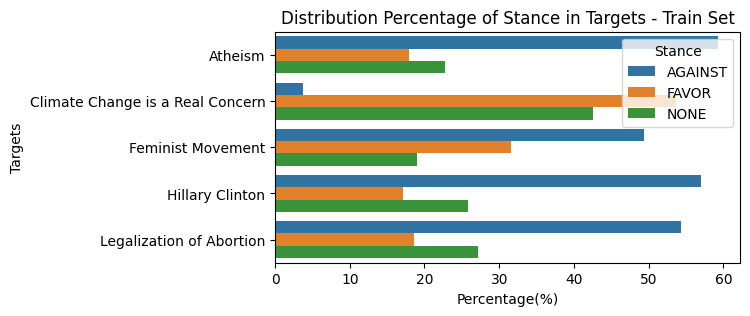

In [17]:
fig = plt.figure(figsize=(6,3))

sns.barplot(x='Percentage', y='Target', hue='Stance', orient='h', data=df_grouped)

plt.title("Distribution Percentage of Stance in Targets - Train Set")
plt.xlabel("Percentage(%)")
plt.ylabel("Targets")

In [18]:
df_test_grouped = df_test.groupby(['Target','Stance']).size().reset_index(name='Count')
counts_test_target = df_test_grouped.groupby('Target')['Count'].transform('sum')
df_test_grouped['Percentage'] = (df_test_grouped['Count'] / counts_test_target) * 100
df_test_grouped.head()

,Target,Stance,Count,Percentage
0,Atheism,AGAINST,160,72.727273
1,Atheism,FAVOR,32,14.545455
2,Atheism,NONE,28,12.727273
3,Climate Change is a Real Concern,AGAINST,11,6.508876
4,Climate Change is a Real Concern,FAVOR,123,72.781065


Text(0, 0.5, 'Targets')

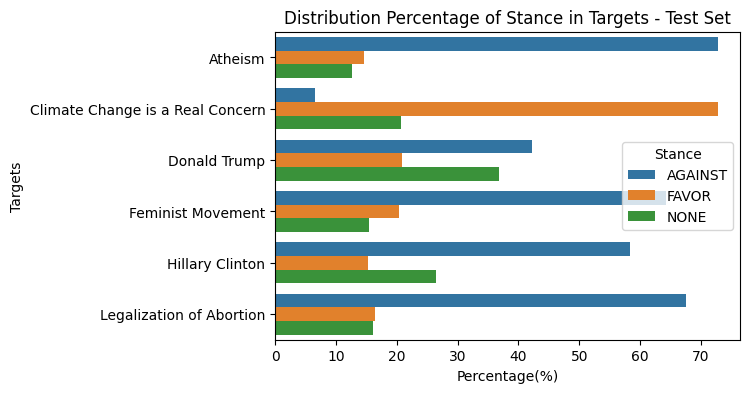

In [19]:
fig = plt.figure(figsize=(6,4))

sns.barplot(x='Percentage', y='Target', hue='Stance', orient='h',errorbar=None, data=df_test_grouped)

plt.title("Distribution Percentage of Stance in Targets - Test Set")
plt.xlabel("Percentage(%)")
plt.ylabel("Targets")

Above two tables show the stance type balance are not balance. It is minority for against "Climate Change is a Real Concern" in both train and test set. Feminist Movement in train set would be balance, but it is not even in test set.

In [20]:
def random_pick(group):
    return group.sample(n=1, random_state=0)

In [21]:
random_samples = df.groupby(['Target', 'Stance'], group_keys=False).apply(random_pick)
random_samples

,Tweet,Target,Stance
213,"#God cares about everything that concerns you,...",Atheism,AGAINST
118,Leaving Christianity enables you to love the p...,Atheism,FAVOR
161,True community is being able to disagree and s...,Atheism,NONE
659,"BREAKING: This just in, an ocean wave just bro...",Climate Change is a Real Concern,AGAINST
1001,We need integrated #science with #indigenous k...,Climate Change is a Real Concern,FAVOR
977,@davidakin @lraitt Installing new #ForestFire ...,Climate Change is a Real Concern,NONE
1406,"IF FEMINISTS WERE HONEST ""I know men don't h...",Feminist Movement,AGAINST
1026,@randomtweetor i hate to break it to u bruh bu...,Feminist Movement,FAVOR
1060,Honoured to be followed by the truly inspirati...,Feminist Movement,NONE
1854,RT @FutureTXLeader: Are y'all #TexasTech #RedR...,Hillary Clinton,AGAINST


In [22]:
df[df['Tweet'].str.contains("God")].groupby('Target').count().reset_index()

,Target,Tweet,Stance
0,Atheism,116,116
1,Climate Change is a Real Concern,3,3
2,Feminist Movement,5,5
3,Hillary Clinton,6,6
4,Legalization of Abortion,30,30


There would be words (e.g. God) which across in all targets. But the importance of the word is not the same with different targets. It could be misleading if the model considered a word as same importance. Therefore, a target is important to distinguish a stance.

## 4. Extra Target in Test set
As there is an extra target (Donald Trump) in the test set. The target should be better to treated as another input. This is another reason to train target as independent input

In [23]:
df_test[df_test['Target'] == "Donald Trump"].head()

,Tweet,Target,Stance
1249,@2014voteblue @ChrisJZullo blindly supporting ...,Donald Trump,NONE
1250,@ThePimpernelX @Cameron_Gray @CalebHowe Total...,Donald Trump,NONE
1251,@JeffYoung @ThePatriot143 I fully support full...,Donald Trump,NONE
1252,@ABC Stupid is as stupid does! Showedhis true ...,Donald Trump,AGAINST
1253,@HouseGOP we now have one political party. The...,Donald Trump,NONE


## 5. ReTweet


In [24]:
df_retweet = df[df['Tweet'].str.contains(retweet_pattern)]
df_retweet.head()

,Tweet,Target,Stance
43,"RT @AnthonyCumia: If Hillary IS elected, I hav...",Hillary Clinton,AGAINST
49,RT @FutureTXLeader: Is everyone in #ElPaso #Te...,Hillary Clinton,AGAINST
65,"RT @TheKeyisPrayer: ""No law can give me the ri...",Legalization of Abortion,AGAINST
112,"RT @prayerbullets: Let the righteousness, peac...",Atheism,AGAINST
139,RT @jeremysumpter: Thank you lord for such a b...,Atheism,AGAINST


In [25]:
df_retweet['Tweet_no_RT'] = df_retweet['Tweet'].str.replace(retweet_pattern, r'', regex=True)
df_retweet['Tweet_no_RT']

<ipython-input-25-54190f1be0b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retweet['Tweet_no_RT'] = df_retweet['Tweet'].str.replace(retweet_pattern, r'', regex=True)


43      If Hillary IS elected, I have my transition te...
49      Is everyone in #ElPaso #Texas ready for presid...
65      "No law can give me the right to do what is wr...
112     Let the righteousness, peace, and joy of the k...
139     Thank you lord for such a beautiful Sunday :) ...
                              ...                        
2727    RT @ProLifeYouth Adopting a child shouldn't co...
2751    @JustinTrudeau try joining the millions of sla...
2752    Why doesn't anyone congratulate me for NOT get...
2833    Who's yer man in the #dail talking about bully...
2890    Yes I will be at @theRallyforLife! Counting do...
Name: Tweet_no_RT, Length: 92, dtype: object

In [26]:
df_RT_join_df = pd.merge(df_retweet, df, left_on="Tweet_no_RT", right_on='Tweet', how='inner')
df_RT_join_df[df_RT_join_df['Tweet_x'] != df_RT_join_df['Tweet_y']]

,Tweet_x,Target_x,Stance_x,Tweet_no_RT,Tweet_y,Target_y,Stance_y
0,RT @WeAreFemstrong: Wonder what it'd be like t...,Feminist Movement,FAVOR,Wonder what it'd be like to wear a dress and N...,Wonder what it'd be like to wear a dress and N...,Feminist Movement,FAVOR
1,RT @gbforchoice: When is abortion a responsibl...,Legalization of Abortion,FAVOR,When is abortion a responsible choice? When a ...,When is abortion a responsible choice? When a ...,Legalization of Abortion,FAVOR
2,RT @FrCharles: .@giannaberettamo @GiaMolla @sp...,Legalization of Abortion,NONE,.@giannaberettamo @GiaMolla @sphcs_news Happy ...,.@giannaberettamo @GiaMolla @sphcs_news Happy ...,Legalization of Abortion,AGAINST


The above table shows that there are 3 RTs which is reposting the tweet in data set. It could be a data leakage if the tweet or RTs are in validation sets.

In [27]:
df_RT_join_df_test = pd.merge(df_retweet, df_test, left_on="Tweet_no_RT", right_on='Tweet', how='inner')
df_RT_join_df_test[df_RT_join_df_test['Tweet_x'] != df_RT_join_df_test['Tweet_y']]

,Tweet_x,Target_x,Stance_x,Tweet_no_RT,Tweet_y,Target_y,Stance_y
0,RT @DogsOfGod: I will fight for the unborn! #S...,Legalization of Abortion,AGAINST,I will fight for the unborn! #SemST,I will fight for the unborn! #SemST,Legalization of Abortion,AGAINST


The above table shows that there is 1 RT in training test which is reposting the tweet in testing data set. It is a data leakage. And, preprocessing with other RTs appearing in the training set must be done.

# PreProcessing

## 1. Removing Retweet with possible data leakage
Retweet could be an issue of data leakage. A retweet in train set could be a tweet from test set . Or, a retweet in train set can be found as a tweet in train set (could be a validation set).

There are 3 RTs in the train set which repost a tweet from train set. And, there is 1 RT in the test set which repost a tweet from train set. It could be considered as a data leakage as the content is exactly the same. Therefore, the 4 RTs are deleted from the training set.

In [28]:
df_RT_join_df['Tweet_x']

0    RT @WeAreFemstrong: Wonder what it'd be like t...
1    RT @gbforchoice: When is abortion a responsibl...
2    RT @FrCharles: .@giannaberettamo @GiaMolla @sp...
Name: Tweet_x, dtype: object

In [29]:
df_remove_RT = df[~df['Tweet'].isin(df_RT_join_df['Tweet_x'])]
df_remove_RT = df_remove_RT[~df_remove_RT['Tweet'].isin(df_RT_join_df_test['Tweet_x'])]
df_remove_RT.reset_index()
df_remove_RT.head()

,Tweet,Target,Stance
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE


## 2. Tokenizer
There are 2 tokenizers could be considered in the task.
1. TweetTokenizer from ntlk
2. Tokenizer from keras

In [30]:
# Tokenize by TweetTokenizer from nltk
def tokenize_series(series):
    tweet_tokenizer = TweetTokenizer(reduce_len=True)
    return [tweet_tokenizer.tokenize(words) for words in series.to_numpy()]

In [31]:
tokenized_tweets = tokenize_series(df_remove_RT['Tweet'])
print(f'Tokens by Tweet Tokenizer: {tokenized_tweets[:2]}')

Tokens by Tweet Tokenizer: [['@tedcruz', 'And', ',', '#HandOverTheServer', 'she', 'wiped', 'clean', '+', '30k', 'deleted', 'emails', ',', 'explains', 'dereliction', 'of', 'duty', '/', 'lies', 're', '#Benghazi', ',', 'etc', '#tcot'], ['Hillary', 'is', 'our', 'best', 'choice', 'if', 'we', 'truly', 'want', 'to', 'continue', 'being', 'a', 'progressive', 'nation', '.', '#Ohio']]


In [32]:
tokenized_targets = tokenize_series(df_remove_RT['Target'])

In [33]:
# Tokenize by Tokenizer from Keras
tokenizer = Tokenizer(lower=False, filters="")
tokenizer.fit_on_texts(df_remove_RT['Tweet'].to_numpy()[:2])

word_index = tokenizer.word_index

t = ["".join(tokens) for tokens, index in word_index.items()]
print(f'Tokens by Tweet Tokenizer: {t}')

Tokens by Tweet Tokenizer: ['@tedcruz', 'And,', '#HandOverTheServer', 'she', 'wiped', 'clean', '+', '30k', 'deleted', 'emails,', 'explains', 'dereliction', 'of', 'duty/lies', 're', '#Benghazi,etc', '#tcot', 'Hillary', 'is', 'our', 'best', 'choice', 'if', 'we', 'truly', 'want', 'to', 'continue', 'being', 'a', 'progressive', 'nation.', '#Ohio']


Tokenizer from Keras will filter all punctuations by default. Important symbols like "#" & "@" in a tweet are also removed. Although the filter can be set by passing an empty string, it treats combination of symbols like ":-)" as 3 separate tokens (i.e. [':', '-', ')']).

TweetTokenizer will not remove any punctuations, and it takes hashtag and mention as a token. It treats combination of symbols as a single token which make more sense.

TweetTokenizer is chosen and manually filter out single punctuation token.

In [34]:
def filter_single_punctuation(tokens):
    filtered_tokens = []
    for token in tokens:
        if not re.match(r"^\W$", token):
            filtered_tokens.append(token)
    return filtered_tokens

filtered_tweets = [filter_single_punctuation(tokens) for tokens in tokenized_tweets]

for tokens in filtered_tweets[:2]:
    print(tokens)


['@tedcruz', 'And', '#HandOverTheServer', 'she', 'wiped', 'clean', '30k', 'deleted', 'emails', 'explains', 'dereliction', 'of', 'duty', 'lies', 're', '#Benghazi', 'etc', '#tcot']
['Hillary', 'is', 'our', 'best', 'choice', 'if', 'we', 'truly', 'want', 'to', 'continue', 'being', 'a', 'progressive', 'nation', '#Ohio']


## 3. HashTag

### Splitting Hashtag and Mention as other rows of data
As hashtag can be a phrases and it usually a combination of more than a word, it could be a challenge task for a neural network to handle them. Usually a tweet without hashtags could have its own meaning. And, a hashtag could also have its own meaning.

In [35]:
def extract_hashtag_mentions(tweets):
    all_hashtags = []
    all_mentions = []
    all_normal_words = []

    for tokens in tweets:
        hashtags = []
        mentions = []
        normal_words = []
        for token in tokens:
            if token.startswith("#"):
                if token != "#SemST":   # exclude hashtag "#SemST"
                    hashtags.append(token)
            elif token.startswith("@"):
                mentions.append(token)
            else:
                normal_words.append(token)
        all_hashtags.append(hashtags)
        all_mentions.append(mentions)
        all_normal_words.append(normal_words)

    return (all_hashtags, all_mentions, all_normal_words)

all_hashtags, all_mentions, all_normal_words = extract_hashtag_mentions(filtered_tweets)
print(all_hashtags[:2])
print(all_mentions[:2])
print(all_normal_words[:2])

[['#HandOverTheServer', '#Benghazi', '#tcot'], ['#Ohio']]
[['@tedcruz'], []]
[['And', 'she', 'wiped', 'clean', '30k', 'deleted', 'emails', 'explains', 'dereliction', 'of', 'duty', 'lies', 're', 'etc'], ['Hillary', 'is', 'our', 'best', 'choice', 'if', 'we', 'truly', 'want', 'to', 'continue', 'being', 'a', 'progressive', 'nation']]


### Preprocessing Hashtags
 Excluding hashtag "#SemST" as it is a tag for collecting data, all tweets in dataset should have it, and it tells nothing about stance. Removing them to save processing power and prevent the network to have vanishing gradient issue. The model could also be overfitted by not generalising the tags.

In [36]:
df_tokenized = pd.concat([df_remove_RT.reset_index(), pd.Series(all_hashtags, name='Hashtag')], axis=1)
df_tokenized = pd.concat([df_tokenized, pd.Series(all_mentions, name='Mention')], axis=1)
df_tokenized = pd.concat([df_tokenized, pd.Series(all_normal_words, name='Tokenized_Tweet')], axis=1)
df_tokenized = pd.concat([df_tokenized, pd.Series(tokenized_targets, name='Tokenized_Target')], axis=1)
# len(df_tokenized)
df_tokenized.head()

,index,Tweet,Target,Stance,Hashtag,Mention,Tokenized_Tweet,Tokenized_Target
0,0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,"[#HandOverTheServer, #Benghazi, #tcot]",[@tedcruz],"[And, she, wiped, clean, 30k, deleted, emails,...","[Hillary, Clinton]"
1,1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,[#Ohio],[],"[Hillary, is, our, best, choice, if, we, truly...","[Hillary, Clinton]"
2,2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,[],[@TheView],"[I, think, our, country, is, ready, for, a, fe...","[Hillary, Clinton]"
3,3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,[#WhyImNotVotingForHillary],[],"[I, just, gave, an, unhealthy, amount, of, my,...","[Hillary, Clinton]"
4,4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,[],[@PortiaABoulger],"[Thank, you, for, adding, me, to, your, list]","[Hillary, Clinton]"


### Pascal Case & Camel Case in hashtags

Do not run a RNN for character to character as it requires much more processing power. Preprocessing it by handling Pascal and Camel Case with Fasttext embedding.

e.g.
WhyImNotVotingForHillary -> Why Im Not Voting For Hillary
HOLYCRAPThatsGoodNews -> HOLYCRAPThats Good News

There may have some issue on missing splitting with some words like example 2. It could be handled with Fasttext embedding as it considered sub-word information (character n-grams). It could handle out-of-vocabulary words.

In [37]:
def pascal_to_word(s):
    s = re.sub(r'([a-z0-9])([A-Z])', r'\1 \2', s)#.lower()
    s = re.sub(r'([A-Z])([0-9])', r'\1 \2', s)#.lower()
    return re.sub(r'([a-zA-Z])([0-9])', r'\1 \2', s).lower()

# pascal_case_str = df_tokenized['HashTags'][0][0][1:] # remove "#" at the 1st character
pascal_case_str = "WhyImNotVotingFor2016Hillary2016"
words = pascal_to_word(pascal_case_str)
print(f'"{pascal_case_str}" to "{words}" after processing.')

"WhyImNotVotingFor2016Hillary2016" to "why im not voting for 2016 hillary 2016" after processing.


In [38]:
df_tokenized['Tokenized_Hashtag'] = df_tokenized['Hashtag'].apply(lambda arr: [pascal_to_word(s[1:]) for s in arr])
df_tokenized.head()

,index,Tweet,Target,Stance,Hashtag,Mention,Tokenized_Tweet,Tokenized_Target,Tokenized_Hashtag
0,0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,"[#HandOverTheServer, #Benghazi, #tcot]",[@tedcruz],"[And, she, wiped, clean, 30k, deleted, emails,...","[Hillary, Clinton]","[hand over the server, benghazi, tcot]"
1,1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,[#Ohio],[],"[Hillary, is, our, best, choice, if, we, truly...","[Hillary, Clinton]",[ohio]
2,2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,[],[@TheView],"[I, think, our, country, is, ready, for, a, fe...","[Hillary, Clinton]",[]
3,3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,[#WhyImNotVotingForHillary],[],"[I, just, gave, an, unhealthy, amount, of, my,...","[Hillary, Clinton]",[why im not voting for hillary]
4,4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,[],[@PortiaABoulger],"[Thank, you, for, adding, me, to, your, list]","[Hillary, Clinton]",[]


## 4. Removing Retweet symbols & masking mention

Retweet symbols does not bring any meaning to the tweet. It may contain values with retweeting by some user. The username may be treated as favor or against to particular target. But, the task is to classify a tweet stance by a single tweet. A mention in a tweet should have no meaning on stance. Let's take a sample of @HillaryClinton. Tweets mentioned @HillaryClinton could be favor or against. They are depends on other words but not the mention. Therefore, retweet symbols and mentions will be removed.

In [39]:
def remove_rt_prefix(tweet):
    if len(tweet) > 0 and tweet[0].startswith("RT"):
        tweet.pop(0)  # Remove the first element if it starts with "RT"
    return tweet

df_tokenized['Tokenized_Tweet'] = df_tokenized['Tokenized_Tweet'].apply(remove_rt_prefix)
df_tokenized

,index,Tweet,Target,Stance,Hashtag,Mention,Tokenized_Tweet,Tokenized_Target,Tokenized_Hashtag
0,0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,"[#HandOverTheServer, #Benghazi, #tcot]",[@tedcruz],"[And, she, wiped, clean, 30k, deleted, emails,...","[Hillary, Clinton]","[hand over the server, benghazi, tcot]"
1,1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,[#Ohio],[],"[Hillary, is, our, best, choice, if, we, truly...","[Hillary, Clinton]",[ohio]
2,2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,[],[@TheView],"[I, think, our, country, is, ready, for, a, fe...","[Hillary, Clinton]",[]
3,3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,[#WhyImNotVotingForHillary],[],"[I, just, gave, an, unhealthy, amount, of, my,...","[Hillary, Clinton]",[why im not voting for hillary]
4,4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,[],[@PortiaABoulger],"[Thank, you, for, adding, me, to, your, list]","[Hillary, Clinton]",[]
...,...,...,...,...,...,...,...,...,...
2905,2909,"There's a law protecting unborn eagles, but no...",Legalization of Abortion,AGAINST,[],[],"[There's, a, law, protecting, unborn, eagles, ...","[Legalization, of, Abortion]",[]
2906,2910,I am 1 in 3... I have had an abortion #Abortio...,Legalization of Abortion,AGAINST,"[#AbortionOnDemand, #MenstruationMatters]",[],"[I, am, 1, in, 3, ..., I, have, had, an, abort...","[Legalization, of, Abortion]","[abortion on demand, menstruation matters]"
2907,2911,How dare you say my sexual preference is a cho...,Legalization of Abortion,AGAINST,[#liberalism],[],"[How, dare, you, say, my, sexual, preference, ...","[Legalization, of, Abortion]",[liberalism]
2908,2912,"Equal rights for those 'born that way', no rig...",Legalization of Abortion,AGAINST,"[#LiberalLogic, #liberalism, #life]",[],"[Equal, rights, for, those, born, that, way, n...","[Legalization, of, Abortion]","[liberal logic, liberalism, life]"


There are 92 retweet filtered out. There could be more RTs as this is using the suggested pattern from X.  

## 5. Data Augmentation and OverSampling

ContextualWordEmbsAug, SynonymAug, BackTranslationAug

model_path: ‘bert-base-uncased’, ‘bert-base-cased’, ‘distilbert-base-uncased’, ‘roberta-base’, ‘distilroberta-base’,
action:  ‘insert or ‘substitute’.

In [40]:
aug = naw.ContextualWordEmbsAug(model_path='bert-base-cased', action="substitute", device="cuda")
augmented_tweet = aug.augment(df_tokenized['Tweet'][0], 3)

print(df_tokenized['Tweet'][0])
print(augmented_tweet)

@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot
['@ She wrote, # t he wiped clean + well with emails, explains responsibility and duty / lies re # y, and # tcot', '@ Part 3, # surely you must clean + 30k Street names, from dereliction of duty / hours on # Benghazi, etc # tcot', '@ tedcruz 1, # HandOverTheServer He leaves S + 30k deleted emails, on commitment versus duty / responsibilities and # Benghazi, etc # and']


In [41]:
tokenized_tweet = " ".join(df_tokenized['Tokenized_Tweet'][0])
augmented_tokenized_tweet = aug.augment(tokenized_tweet, 3)

print(tokenized_tweet)
print(augmented_tokenized_tweet)

And she wiped clean 30k deleted emails explains dereliction of duty lies re etc
['And she has it 30k times It explains dereliction of home w re etc', 'As she wiped the 30k deleted words explains love without writing lies re etc', 'And even wiped clean 30k deleted emails and it and the v re etc']


In [42]:
df_grouped['Target_Max'] = df_grouped.groupby('Target')['Count'].transform('max')
df_grouped['Diff'] = df_grouped["Target_Max"] - df_grouped["Count"]
df_grouped

,Target,Stance,Count,Percentage,Target_Max,Diff
0,Atheism,AGAINST,304,59.259259,304,0
1,Atheism,FAVOR,92,17.933723,304,212
2,Atheism,NONE,117,22.807018,304,187
3,Climate Change is a Real Concern,AGAINST,15,3.797468,212,197
4,Climate Change is a Real Concern,FAVOR,212,53.670886,212,0
5,Climate Change is a Real Concern,NONE,168,42.531646,212,44
6,Feminist Movement,AGAINST,328,49.397590,328,0
7,Feminist Movement,FAVOR,210,31.626506,328,118
8,Feminist Movement,NONE,126,18.975904,328,202
9,Hillary Clinton,AGAINST,393,57.039187,393,0


In [43]:
df_random_record = pd.DataFrame()
for index, row in df_grouped.iterrows():
    df_temp = df_tokenized[(df_tokenized['Target'] == row['Target']) & (df_tokenized['Stance'] == row['Stance'])]
    random_record = df_temp.sample(n=row['Diff'], replace=True)
    df_random_record = pd.concat([df_random_record, random_record], axis=0)
df_random_record

,index,Tweet,Target,Stance,Hashtag,Mention,Tokenized_Tweet,Tokenized_Target,Tokenized_Hashtag
472,472,Happiness is the pursuit of life and liberty. ...,Atheism,FAVOR,"[#TheLUPOL, #theism, #futurism]",[],"[Happiness, is, the, pursuit, of, life, and, l...",[Atheism],"[the lupol, theism, futurism]"
414,414,I am against religion because it teaches us to...,Atheism,FAVOR,[],[@RichardDawkins],"[I, am, against, religion, because, it, teache...",[Atheism],[]
406,406,@AmyMek The establishment clause sets our coun...,Atheism,FAVOR,[],[@AmyMek],"[The, establishment, clause, sets, our, countr...",[Atheism],[]
416,416,A pair of hands working 2gether is far better ...,Atheism,FAVOR,[#FreedomFromReligion],[],"[A, pair, of, hands, working, 2gether, is, far...",[Atheism],[freedom from religion]
150,150,Evidence-based thought just works out better t...,Atheism,FAVOR,[#freethinker],[],"[Evidence-based, thought, just, works, out, be...",[Atheism],[freethinker]
...,...,...,...,...,...,...,...,...,...
2542,2546,@kilcurry in those hospitals that signed up to...,Legalization of Abortion,NONE,[],[@kilcurry],"[in, those, hospitals, that, signed, up, to, t...","[Legalization, of, Abortion]",[]
2603,2607,Undergirding every important issue today is th...,Legalization of Abortion,NONE,"[#marriage, #racism, #gender]",[],"[Undergirding, every, important, issue, today,...","[Legalization, of, Abortion]","[marriage, racism, gender]"
2495,2499,"@CrushTheCFR Yes, heard you the first 500 time...",Legalization of Abortion,NONE,[],[@CrushTheCFR],"[Yes, heard, you, the, first, 500, times, you,...","[Legalization, of, Abortion]",[]
2603,2607,Undergirding every important issue today is th...,Legalization of Abortion,NONE,"[#marriage, #racism, #gender]",[],"[Undergirding, every, important, issue, today,...","[Legalization, of, Abortion]","[marriage, racism, gender]"


In [44]:
df_random_record['Augmented_Tweet'] = df_random_record['Tokenized_Tweet'].apply(lambda x: " ".join(x)).apply(lambda x: aug.augment(x)[0])
df_random_record.head()

,index,Tweet,Target,Stance,Hashtag,Mention,Tokenized_Tweet,Tokenized_Target,Tokenized_Hashtag,Augmented_Tweet
472,472,Happiness is the pursuit of life and liberty. ...,Atheism,FAVOR,"[#TheLUPOL, #theism, #futurism]",[],"[Happiness, is, the, pursuit, of, life, and, l...",[Atheism],"[the lupol, theism, futurism]",Happiness is rational pursuit of life with suc...
414,414,I am against religion because it teaches us to...,Atheism,FAVOR,[],[@RichardDawkins],"[I, am, against, religion, because, it, teache...",[Atheism],[],I am against religion until God teaches us to ...
406,406,@AmyMek The establishment clause sets our coun...,Atheism,FAVOR,[],[@AmyMek],"[The, establishment, clause, sets, our, countr...",[Atheism],[],Our statute thus sets our authority apart and ...
416,416,A pair of hands working 2gether is far better ...,Atheism,FAVOR,[#FreedomFromReligion],[],"[A, pair, of, hands, working, 2gether, is, far...",[Atheism],[freedom from religion],This display of hands that 2gether is far that...
150,150,Evidence-based thought just works out better t...,Atheism,FAVOR,[#freethinker],[],"[Evidence-based, thought, just, works, out, be...",[Atheism],[freethinker],Location - based thought also works out better...


In [45]:
tokenized_aug_tweets = tokenize_series(df_random_record['Augmented_Tweet'])
filtered_aug_tweets = [filter_single_punctuation(tokens) for tokens in tokenized_aug_tweets]
aug_hashtags, aug_mentions, aug_normal_words = extract_hashtag_mentions(filtered_aug_tweets)

In [46]:
df_random_record_copy = df_random_record.copy(deep=True)
df_random_record_copy = df_random_record_copy.reset_index(drop=True)
df_random_record_copy['Tokenized_Tweet'] = pd.Series(aug_normal_words)

df_random_record_copy = df_random_record_copy.drop(['index', 'Augmented_Tweet'], axis=1)
df_random_record_copy

,Tweet,Target,Stance,Hashtag,Mention,Tokenized_Tweet,Tokenized_Target,Tokenized_Hashtag
0,Happiness is the pursuit of life and liberty. ...,Atheism,FAVOR,"[#TheLUPOL, #theism, #futurism]",[],"[Happiness, is, rational, pursuit, of, life, w...",[Atheism],"[the lupol, theism, futurism]"
1,I am against religion because it teaches us to...,Atheism,FAVOR,[],[@RichardDawkins],"[I, am, against, religion, until, God, teaches...",[Atheism],[]
2,@AmyMek The establishment clause sets our coun...,Atheism,FAVOR,[],[@AmyMek],"[Our, statute, thus, sets, our, authority, apa...",[Atheism],[]
3,A pair of hands working 2gether is far better ...,Atheism,FAVOR,[#FreedomFromReligion],[],"[This, display, of, hands, that, 2gether, is, ...",[Atheism],[freedom from religion]
4,Evidence-based thought just works out better t...,Atheism,FAVOR,[#freethinker],[],"[Location, based, thought, also, works, out, b...",[Atheism],[freethinker]
...,...,...,...,...,...,...,...,...
1857,@kilcurry in those hospitals that signed up to...,Legalization of Abortion,NONE,[],[@kilcurry],"[in, those, hospitals, that, signed, on, for, ...","[Legalization, of, Abortion]",[]
1858,Undergirding every important issue today is th...,Legalization of Abortion,NONE,"[#marriage, #racism, #gender]",[],"[Undergirding, this, important, factor, it, is...","[Legalization, of, Abortion]","[marriage, racism, gender]"
1859,"@CrushTheCFR Yes, heard you the first 500 time...",Legalization of Abortion,NONE,[],[@CrushTheCFR],"[Yes, or, you, the, maximum, 500, times, you, ...","[Legalization, of, Abortion]",[]
1860,Undergirding every important issue today is th...,Legalization of Abortion,NONE,"[#marriage, #racism, #gender]",[],"[Undergirding, every, important, matter, today...","[Legalization, of, Abortion]","[marriage, racism, gender]"


In [47]:
df_tokenized = df_tokenized.drop(['index'], axis=1)
df_tokenized

,Tweet,Target,Stance,Hashtag,Mention,Tokenized_Tweet,Tokenized_Target,Tokenized_Hashtag
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,"[#HandOverTheServer, #Benghazi, #tcot]",[@tedcruz],"[And, she, wiped, clean, 30k, deleted, emails,...","[Hillary, Clinton]","[hand over the server, benghazi, tcot]"
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,[#Ohio],[],"[Hillary, is, our, best, choice, if, we, truly...","[Hillary, Clinton]",[ohio]
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,[],[@TheView],"[I, think, our, country, is, ready, for, a, fe...","[Hillary, Clinton]",[]
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,[#WhyImNotVotingForHillary],[],"[I, just, gave, an, unhealthy, amount, of, my,...","[Hillary, Clinton]",[why im not voting for hillary]
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,[],[@PortiaABoulger],"[Thank, you, for, adding, me, to, your, list]","[Hillary, Clinton]",[]
...,...,...,...,...,...,...,...,...
2905,"There's a law protecting unborn eagles, but no...",Legalization of Abortion,AGAINST,[],[],"[There's, a, law, protecting, unborn, eagles, ...","[Legalization, of, Abortion]",[]
2906,I am 1 in 3... I have had an abortion #Abortio...,Legalization of Abortion,AGAINST,"[#AbortionOnDemand, #MenstruationMatters]",[],"[I, am, 1, in, 3, ..., I, have, had, an, abort...","[Legalization, of, Abortion]","[abortion on demand, menstruation matters]"
2907,How dare you say my sexual preference is a cho...,Legalization of Abortion,AGAINST,[#liberalism],[],"[How, dare, you, say, my, sexual, preference, ...","[Legalization, of, Abortion]",[liberalism]
2908,"Equal rights for those 'born that way', no rig...",Legalization of Abortion,AGAINST,"[#LiberalLogic, #liberalism, #life]",[],"[Equal, rights, for, those, born, that, way, n...","[Legalization, of, Abortion]","[liberal logic, liberalism, life]"


In [48]:
df_aug_all = pd.concat([df_tokenized, df_random_record_copy]).reset_index()
df_aug_all

,index,Tweet,Target,Stance,Hashtag,Mention,Tokenized_Tweet,Tokenized_Target,Tokenized_Hashtag
0,0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,"[#HandOverTheServer, #Benghazi, #tcot]",[@tedcruz],"[And, she, wiped, clean, 30k, deleted, emails,...","[Hillary, Clinton]","[hand over the server, benghazi, tcot]"
1,1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,[#Ohio],[],"[Hillary, is, our, best, choice, if, we, truly...","[Hillary, Clinton]",[ohio]
2,2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,[],[@TheView],"[I, think, our, country, is, ready, for, a, fe...","[Hillary, Clinton]",[]
3,3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,[#WhyImNotVotingForHillary],[],"[I, just, gave, an, unhealthy, amount, of, my,...","[Hillary, Clinton]",[why im not voting for hillary]
4,4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,[],[@PortiaABoulger],"[Thank, you, for, adding, me, to, your, list]","[Hillary, Clinton]",[]
...,...,...,...,...,...,...,...,...,...
4767,1857,@kilcurry in those hospitals that signed up to...,Legalization of Abortion,NONE,[],[@kilcurry],"[in, those, hospitals, that, signed, on, for, ...","[Legalization, of, Abortion]",[]
4768,1858,Undergirding every important issue today is th...,Legalization of Abortion,NONE,"[#marriage, #racism, #gender]",[],"[Undergirding, this, important, factor, it, is...","[Legalization, of, Abortion]","[marriage, racism, gender]"
4769,1859,"@CrushTheCFR Yes, heard you the first 500 time...",Legalization of Abortion,NONE,[],[@CrushTheCFR],"[Yes, or, you, the, maximum, 500, times, you, ...","[Legalization, of, Abortion]",[]
4770,1860,Undergirding every important issue today is th...,Legalization of Abortion,NONE,"[#marriage, #racism, #gender]",[],"[Undergirding, every, important, matter, today...","[Legalization, of, Abortion]","[marriage, racism, gender]"


In [49]:
df_grouped_2 = df_aug_all.groupby(['Target','Stance']).size().reset_index(name='Count')
counts_target_2 = df_grouped_2.groupby('Target')['Count'].transform('sum')
df_grouped_2['Percentage'] = (df_grouped_2['Count'] / counts_target_2) * 100
df_grouped_2

,Target,Stance,Count,Percentage
0,Atheism,AGAINST,304,33.333333
1,Atheism,FAVOR,304,33.333333
2,Atheism,NONE,304,33.333333
3,Climate Change is a Real Concern,AGAINST,212,33.333333
4,Climate Change is a Real Concern,FAVOR,212,33.333333
5,Climate Change is a Real Concern,NONE,212,33.333333
6,Feminist Movement,AGAINST,328,33.367243
7,Feminist Movement,FAVOR,327,33.265514
8,Feminist Movement,NONE,328,33.367243
9,Hillary Clinton,AGAINST,393,33.333333


Text(0, 0.5, 'Targets')

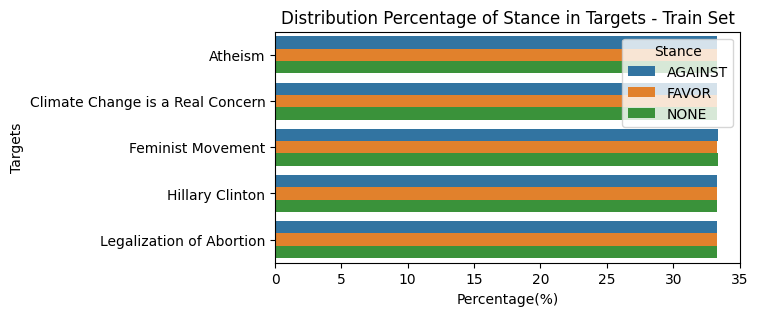

In [50]:
fig = plt.figure(figsize=(6,3))

sns.barplot(x='Percentage', y='Target', hue='Stance', orient='h', data=df_grouped_2)

plt.title("Distribution Percentage of Stance in Targets - Train Set")
plt.xlabel("Percentage(%)")
plt.ylabel("Targets")

## 6. Apply lower case to all tokens
for word embedding

In [51]:
EMBED_INPUT_NAMES = ['Tokenized_Tweet', 'Tokenized_Hashtag', 'Tokenized_Target']

In [52]:
def lowercase_array(arr):
    return np.asarray([s.lower() for s in arr])

for input_name in EMBED_INPUT_NAMES:
    df_aug_all[input_name] = df_aug_all[[input_name]].applymap(lowercase_array)

df_aug_all.head()

,index,Tweet,Target,Stance,Hashtag,Mention,Tokenized_Tweet,Tokenized_Target,Tokenized_Hashtag
0,0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,"[#HandOverTheServer, #Benghazi, #tcot]",[@tedcruz],"[and, she, wiped, clean, 30k, deleted, emails,...","[hillary, clinton]","[hand over the server, benghazi, tcot]"
1,1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,[#Ohio],[],"[hillary, is, our, best, choice, if, we, truly...","[hillary, clinton]",[ohio]
2,2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,[],[@TheView],"[i, think, our, country, is, ready, for, a, fe...","[hillary, clinton]",[]
3,3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,[#WhyImNotVotingForHillary],[],"[i, just, gave, an, unhealthy, amount, of, my,...","[hillary, clinton]",[why im not voting for hillary]
4,4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,[],[@PortiaABoulger],"[thank, you, for, adding, me, to, your, list]","[hillary, clinton]",[]


Both augmented original and tokenized tweet seems doesn't make much sense. The augmented original tweet has an important issue that it tokenized the mentions and hashtags and tried to augment them. Also, the symbols of '@' & '#' are separated with the text after augmented. Therefore, augment tokenized tweet is chosen and no hashtag nor mention will be augmented.

## 7. Word Index

In [53]:
def create_word_index(words):
    word_index = {}
    index = 1 # 0 for empty value

    for word in words:
        if word not in word_index:
            word_index[index] = word
            index += 1

    return word_index

In [54]:
ALL_WORD_INDEX = {}
for input_name in EMBED_INPUT_NAMES:
    tokens = []
    [tokens.extend(arr) for arr in df_aug_all[input_name]]
    word_index = create_word_index(set(tokens))
    ALL_WORD_INDEX[input_name] = word_index

    print(f'Length of distinct {input_name}: {len(word_index)+1}')

Length of distinct Tokenized_Tweet: 7925
Length of distinct Tokenized_Hashtag: 2009
Length of distinct Tokenized_Target: 15


In [55]:
def max_array_length(arrays):
    return max((len(arr) for arr in arrays), default=0)

In [56]:
ALL_INPUT_MAX_LENGTHS = {}
for input_name in EMBED_INPUT_NAMES:
    ALL_INPUT_MAX_LENGTHS[input_name] = max_array_length(df_aug_all[input_name])

print(f'Max length of : {ALL_INPUT_MAX_LENGTHS}]')

Max length of : {'Tokenized_Tweet': 31, 'Tokenized_Hashtag': 11, 'Tokenized_Target': 6}]


In [57]:
def pad_sequence(arr, word_index, max_length):
    return_arr = np.zeros(max_length, dtype=int)
    for i, word in enumerate(arr):
        for key, value in word_index.items():
            if value == word:
                return_arr[i] = key
    return return_arr

for input_name in EMBED_INPUT_NAMES:
    df_aug_all['Pad_'+input_name] = df_aug_all[[input_name]].applymap(lambda arr: pad_sequence(arr, ALL_WORD_INDEX[input_name], ALL_INPUT_MAX_LENGTHS[input_name]))

df_aug_all.head()

,index,Tweet,Target,Stance,Hashtag,Mention,Tokenized_Tweet,Tokenized_Target,Tokenized_Hashtag,Pad_Tokenized_Tweet,Pad_Tokenized_Hashtag,Pad_Tokenized_Target
0,0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,"[#HandOverTheServer, #Benghazi, #tcot]",[@tedcruz],"[and, she, wiped, clean, 30k, deleted, emails,...","[hillary, clinton]","[hand over the server, benghazi, tcot]","[212, 6754, 3886, 6250, 5215, 4907, 4481, 7878...","[586, 1506, 1084, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 12, 0, 0, 0, 0]"
1,1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,[#Ohio],[],"[hillary, is, our, best, choice, if, we, truly...","[hillary, clinton]",[ohio],"[3274, 4004, 757, 6831, 5104, 4717, 3224, 1604...","[337, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 12, 0, 0, 0, 0]"
2,2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,[],[@TheView],"[i, think, our, country, is, ready, for, a, fe...","[hillary, clinton]",[],"[2577, 278, 757, 3281, 4004, 3021, 7858, 2212,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 12, 0, 0, 0, 0]"
3,3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,[#WhyImNotVotingForHillary],[],"[i, just, gave, an, unhealthy, amount, of, my,...","[hillary, clinton]",[why im not voting for hillary],"[2577, 3267, 38, 3573, 518, 7346, 1530, 1739, ...","[1520, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 12, 0, 0, 0, 0]"
4,4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,[],[@PortiaABoulger],"[thank, you, for, adding, me, to, your, list]","[hillary, clinton]",[],"[2568, 7559, 7858, 2805, 6976, 6128, 5668, 163...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 12, 0, 0, 0, 0]"


## 7. Encoding Stance

In [58]:
stance_encoder = OneHotEncoder(sparse_output=False, dtype=int)

encoded_categories = stance_encoder.fit_transform(df_aug_all[['Stance']])
df_encoded_stance = pd.DataFrame(encoded_categories, columns=stance_encoder.get_feature_names_out(['Stance']))

df_train = pd.concat([df_aug_all, df_encoded_stance], axis=1)
df_train = df_train.reset_index()
df_train.head()

,index,Tweet,Target,Stance,Hashtag,Mention,Tokenized_Tweet,Tokenized_Target,Tokenized_Hashtag,Pad_Tokenized_Tweet,Pad_Tokenized_Hashtag,Pad_Tokenized_Target,Stance_AGAINST,Stance_FAVOR,Stance_NONE
0,0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,"[#HandOverTheServer, #Benghazi, #tcot]",[@tedcruz],"[and, she, wiped, clean, 30k, deleted, emails,...","[hillary, clinton]","[hand over the server, benghazi, tcot]","[212, 6754, 3886, 6250, 5215, 4907, 4481, 7878...","[586, 1506, 1084, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 12, 0, 0, 0, 0]",1,0,0
1,1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,[#Ohio],[],"[hillary, is, our, best, choice, if, we, truly...","[hillary, clinton]",[ohio],"[3274, 4004, 757, 6831, 5104, 4717, 3224, 1604...","[337, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 12, 0, 0, 0, 0]",0,1,0
2,2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,[],[@TheView],"[i, think, our, country, is, ready, for, a, fe...","[hillary, clinton]",[],"[2577, 278, 757, 3281, 4004, 3021, 7858, 2212,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 12, 0, 0, 0, 0]",1,0,0
3,3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,[#WhyImNotVotingForHillary],[],"[i, just, gave, an, unhealthy, amount, of, my,...","[hillary, clinton]",[why im not voting for hillary],"[2577, 3267, 38, 3573, 518, 7346, 1530, 1739, ...","[1520, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 12, 0, 0, 0, 0]",1,0,0
4,4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,[],[@PortiaABoulger],"[thank, you, for, adding, me, to, your, list]","[hillary, clinton]",[],"[2568, 7559, 7858, 2805, 6976, 6128, 5668, 163...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 12, 0, 0, 0, 0]",0,0,1


# Data Splitting

Split Training and Validation set into 7:3 according to its target. There is no need to balance stance, as it is already balanced with augmented data.

In [15]:
df_train = pd.read_csv('aug_df_train.csv', encoding="unicode_escape", lineterminator='\n')

In [16]:
X_stacked = np.hstack((np.array(df_train['Pad_Tokenized_Tweet'].tolist()), np.array(df_train['Pad_Tokenized_Hashtag'].tolist())))

X_train, X_val, y_train, y_val = train_test_split(X_stacked, df_train[['Stance_AGAINST', 'Stance_FAVOR','Stance_NONE']], test_size=0.3, random_state=1)


ValueError: Found input variables with inconsistent numbers of samples: [9544, 4772]

In [60]:
X_train_tweet = X_train[:, :ALL_INPUT_MAX_LENGTHS['Tokenized_Tweet']]
X_train_hashtag = X_train[:, ALL_INPUT_MAX_LENGTHS['Tokenized_Tweet'] : (ALL_INPUT_MAX_LENGTHS['Tokenized_Tweet'] + ALL_INPUT_MAX_LENGTHS['Tokenized_Hashtag'])]
X_train_target = X_train[:, ALL_INPUT_MAX_LENGTHS['Tokenized_Tweet'] + ALL_INPUT_MAX_LENGTHS['Tokenized_Hashtag']:]

X_val_tweet = X_val[:, :ALL_INPUT_MAX_LENGTHS['Tokenized_Tweet']]
X_val_hashtag = X_val[:, ALL_INPUT_MAX_LENGTHS['Tokenized_Tweet'] : (ALL_INPUT_MAX_LENGTHS['Tokenized_Tweet'] + ALL_INPUT_MAX_LENGTHS['Tokenized_Hashtag'])]
X_val_target = X_val[:, ALL_INPUT_MAX_LENGTHS['Tokenized_Tweet'] + ALL_INPUT_MAX_LENGTHS['Tokenized_Hashtag']:]

In [61]:
print(f'Dimension of X_train: ({len(X_train)}, {len(X_train[0])})')


3340
48


Packed 3 columns (Tokenized_Tweet, Tokenized_Hashtag & Target) into a numpy array, as the tensorflow model requires 1 X_train for fitting.

# Transfer Learning
## Tranfomer
### 1. BERT - Bidirectional Encoder Representations from Transformers
Sth about BERT

## Word Embedding

There are serval choices of word embedding to choose. E.g. GloVe, Word2Vec and Fasttext. Here we compare Fasttext with GloVe.

### 1. Fasttext

In [63]:
!cp /content/drive/'My Drive'/Deeplearning/crawl-300d-2M-subword.zip .
!unzip -q crawl-300d-2M-subword.zip

In [64]:
# Load FastText word embeddings (change the path to your embeddings file)
# fasttext.util.download_model('en', if_exists='ignore')  # Downlaoad English model
ft = fasttext.load_model('crawl-300d-2M-subword/crawl-300d-2M-subword.bin')  # Load FastText model
EMBEDDING_DIM = 300  # FastText embeddings dimension

ValueError: ignored

In [67]:
not_existing_word = "foundationscandal"

In [ ]:
print(f'Fasttext embedding of a not existing word ({not_existing_word}): {ft.get_word_vector(not_existing_word)}')

### 2. GloVe

In [65]:
!cp /content/drive/'My Drive'/Deeplearning/glove.6B.100d.txt .

In [66]:
file = open('glove.6B.100d.txt', encoding='utf-8')

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

In [68]:
print(f'GloVe embedding of a not existing word ({not_existing_word}): {glove_vectors.get(not_existing_word)}')

GloVe embedding of a not existing word (foundationscandal): None


Fasttext can return a vector for out-of-vocabulary word. It could be better representation in analysing data from social media which may have slang, "new" words and misspelling words. However, GloVe and Word2Vec cannot provide any representation vector if the word does not exist in their corpus.

#### Applying Fasttext

In [ ]:
def create_embedding(df, input_name):
    embedding = [np.zeros(EMBEDDING_DIM)] # init a 0 vector for empty value
    all_tokens = np.concatenate(df[input_name].values)
    print(f'no. of distinct {input_name}: {len(set(all_tokens))}')
    for idx, token in enumerate(set(all_tokens)):
        embedding.append(ft.get_word_vector(token))
    return np.array(embedding)

def create_embeddings_for_model(df, input_names = EMBED_INPUT_NAMES):
    embedding_dict = {}
    for input_name in input_names:
        embedding_dict[input_name] = create_embedding(df, input_name)
    return embedding_dict

EMBEDDING_DICT = create_embeddings_for_model(df_aug_all, EMBED_INPUT_NAMES)

for input_name in EMBED_INPUT_NAMES:
    print(f'Dimension of {input_name}: {EMBEDDING_DICT[input_name].shape}')

# Modelling
## Base Model

The base model consists of 3 inputs. They are `Tweet`, `Hashtag` and `Target`. It is a multi-in-single-out model.

`Tweet` has been removed mentions and hashtags. It will be embedded with Fasttext and pass to two bi-directional LSTM layer.
All `Hashtag`s are combined into another input of the model. Although some hashtags is single words, it could be a phrase, and they are split with CamelCase. A bi-directional LSTM and a LSTM are employed.
`Target` could be a word or a phrase. There are only 5 targets in the train set and they are not sentences. So, a LSTM could be enough for the model.  

In [ ]:
input_tweet = Input(shape=(ALL_INPUT_MAX_LENGTHS['Tokenized_Tweet'],), name="input_tweet_layer")
tweet_layer = Embedding(len(EMBEDDING_DICT['Tokenized_Tweet']),
                        EMBEDDING_DIM,
                        weights=[EMBEDDING_DICT['Tokenized_Tweet']],
                        input_length=ALL_INPUT_MAX_LENGTHS['Tokenized_Tweet'],
                        trainable=False,
                        name="tweet_embedding_layer")
tweet_embedding = tweet_layer(input_tweet)
tweet_embedding = Bidirectional(LSTM(units=128, dropout=0.8, recurrent_dropout=0.8, return_sequences=True), name="tweet_LSTM")(tweet_embedding)
tweet_embedding = Bidirectional(LSTM(units=64, dropout=0.8, recurrent_dropout=0.8, return_sequences=False), name="tweet_LSTM_2")(tweet_embedding)

input_hashtag = Input(shape=(ALL_INPUT_MAX_LENGTHS['Tokenized_Hashtag'],), name="input_hashtag_layer")
hashtag_layer = Embedding(len(EMBEDDING_DICT['Tokenized_Hashtag']),
                          EMBEDDING_DIM,
                          weights=[EMBEDDING_DICT['Tokenized_Hashtag']],
                          input_length=ALL_INPUT_MAX_LENGTHS['Tokenized_Hashtag'],
                          trainable=False,
                          name="hashtag_embedding_layer")
hashtag_embedding = hashtag_layer(input_hashtag)
hashtag_embedding = Bidirectional(LSTM(units=64, dropout=0.8, recurrent_dropout=0.8, return_sequences=True), name="hashtag_LSTM")(hashtag_embedding)
hashtag_embedding = LSTM(units=32, dropout=0.8, recurrent_dropout=0.8, return_sequences=False, name="hashtag_LSTM_2")(hashtag_embedding)

input_target = Input(shape=(ALL_INPUT_MAX_LENGTHS['Tokenized_Target'],), name="input_target_layer")
target_layer = Embedding(len(EMBEDDING_DICT['Tokenized_Target']),
                         EMBEDDING_DIM,
                         weights=[EMBEDDING_DICT['Tokenized_Target']],
                         input_length=ALL_INPUT_MAX_LENGTHS['Tokenized_Target'],
                         trainable=False,
                         name="target_embedding_layer")
target_embedding = target_layer(input_target)
target_embedding = LSTM(units=16, dropout=0.8, recurrent_dropout=0.8, return_sequences=False, name="target_LSTM")(target_embedding)

model_concat = concatenate([tweet_embedding, hashtag_embedding, target_embedding])
model_concat = Flatten()(model_concat)
model_concat = tf.keras.layers.Dense(128, activation='relu')(model_concat)
model_concat = tf.keras.layers.Dropout(0.5)(model_concat)
model_concat = tf.keras.layers.Dense(64, activation='relu')(model_concat)
model_concat = tf.keras.layers.Dropout(0.5)(model_concat)
model_concat = Dense(3, activation='sigmoid')(model_concat)

model = Model(inputs=[input_tweet, input_hashtag, input_target], outputs=model_concat, name="model_concat")

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
m_histories = {}


In [ ]:
m_histories['base_model'] = model.fit([X_train_tweet, X_train_hashtag, X_train_target], y_train,
                                            epochs=60,
                                            batch_size = 16,
                   validation_data=([X_val_tweet, X_val_hashtag, X_val_target], y_val),
                    # validation_steps=30,
                    verbose=1,
                    # callbacks=get_callbacks('models/base_model')
)

In [ ]:
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

In [ ]:
plotter(m_histories, ylim=[0.4, 0.8], metric = 'accuracy')

In [ ]:
model.save_weights('base_model.h5')

## Improve Model

In [ ]:
def split_df_by_target(df):
    df_dict = {}
    distinct_targets = df['Target'].unique().tolist()
    for target in distinct_targets:
        df_dict[target] = df[df['Target'] == target]
    return df_dict

def split_df_with_target(df, test_size=0.3, random_state=1):
    df_dict = split_df_by_target(df)
    X_train, X_val, y_train, y_val = None, None, None, None
    for keys in df_dict:
        df = df_dict[keys]
        X = df[['Pad_Tokenized_Tweet', 'Pad_Tokenized_Hashtag', 'Pad_Tokenized_Target']]
        y = df[['Stance_AGAINST', 'Stance_FAVOR','Stance_NONE']]
        X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(X, y, test_size=test_size, random_state=random_state)
        if X_train is None:
            X_train, X_val, y_train, y_val = X_train_t, X_val_t, y_train_t, y_val_t
        else:
            X_train = pd.concat([X_train, X_train_t])
            X_val = pd.concat([X_val, X_val_t])
            y_train = pd.concat([y_train, y_train_t])
            y_val = pd.concat([y_val, y_val_t])

            X_train.reset_index(drop=True, inplace=True)
            X_val.reset_index(drop=True, inplace=True)
            y_train.reset_index(drop=True, inplace=True)
            y_val.reset_index(drop=True, inplace=True)
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = split_df_with_target(df_train, test_size=0.3, random_state=1)
X_train

In [ ]:
X_train_tweet = np.array(X_train['Pad_Tokenized_Tweet'].tolist())
X_train_hashtag = np.array(X_train['Pad_Tokenized_Hashtag'].tolist())
X_train_target = np.array(X_train['Pad_Tokenized_Target'].tolist())

X_val_tweet = np.array(X_val['Pad_Tokenized_Tweet'].tolist())
X_val_hashtag = np.array(X_val['Pad_Tokenized_Hashtag'].tolist())
X_val_target = np.array(X_val['Pad_Tokenized_Target'].tolist())


In [ ]:
m_histories['split_model'] = model.fit([X_train_tweet, X_train_hashtag, X_train_target], y_train,
                                            epochs=60,
                                            batch_size = 16,
                   validation_data=([X_val_tweet, X_val_hashtag, X_val_target], y_val),
                    # validation_steps=30,
                    verbose=1,
                    # callbacks=get_callbacks('models/base_model')
)

In [ ]:
plotter(m_histories, ylim=[0.4, 0.8], metric = 'accuracy')

# Test and Ultimate Judgement

--------

# Workings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Sample word vectors (replace with your own)
word_vectors = {
    'benghazi': glove_vectors.get("King"),
    # 'Benghazi': glove_vectors.get("Benghazi"),
    'libya': glove_vectors.get("king"),
    'apple': glove_vectors.get("apple"),

}

# Select the words you want to visualize
words_to_visualize = ['king', 'queen', 'man', 'woman', 'apple']

# Extract word vectors for the selected words
word_vectors_to_visualize = np.array([word_vectors[word] for word in word_vectors.keys()])

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=1, random_state=42)
word_vectors_2D = tsne.fit_transform(word_vectors_to_visualize)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(word_vectors_2D[:, 0], word_vectors_2D[:, 1], marker='o')

# Add labels for each point
for i, word in enumerate(word_vectors.keys()):
    plt.annotate(word, (word_vectors_2D[i, 0], word_vectors_2D[i, 1]))

plt.title('Word Vector Visualization using t-SNE')
plt.show()
